In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install datasets
%pip install transformers
%pip install torch

from datasets import load_dataset, Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

Loading in Dataset


In [2]:
ds = load_dataset("Hemg/Melanoma-Cancer-Image-Dataset")
ds = ds.shuffle()

ds_train= ds['train'][:7520]
ds_train = Dataset.from_dict(ds_train)

ds_test3 = ds['train'][7520:8520]
ds_test3 = Dataset.from_dict(ds_test3)

ds_test2= ds['train'][8520:9520]
ds_test2 = Dataset.from_dict(ds_test2)

ds_test= ds['train'][9520:10710]
ds_test = Dataset.from_dict(ds_test)

ds_val= ds['train'][10710:]
ds_val = Dataset.from_dict(ds_val)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/577 [00:00<?, ?B/s]

(…)-00000-of-00001-01148daec2698532.parquet:   0%|          | 0.00/69.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11879 [00:00<?, ? examples/s]

Loading in EfficientNet-B0 Configuration


In [3]:
from transformers import EfficientNetConfig, EfficientNetForImageClassification
import torch

# Initializing a EfficientNet efficientnet-b7 style configuration
configuration = EfficientNetConfig()

#Storing model in GPU
device = torch.device("cuda")

# Initializing a model (with random weights) from the efficientnet-b7 style configuration
model = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b7")
model = model.to(device)




config.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/267M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

Constructing EfficientNet image processor to be used through data loader

In [4]:
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoImageProcessor, EfficientNetForImageClassification
from tqdm import tqdm


image_processor = AutoImageProcessor.from_pretrained("google/efficientnet-b7")
images = list(ds_val['image'])
labels = list(ds_val['label'])
class CustomDataset(Dataset):
    def __init__(self, images, labels,processor):
        self.images = images
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            images = [self.images[i] for i in idx]
            labels = [self.labels[i] for i in idx]
        else:
            images = [self.images[idx]]
            labels = [self.labels[idx]]
        # Preprocess the image and return as tensor
        processed = self.processor(images=images, return_tensors="pt", padding=True)
        pixel_values = processed["pixel_values"]
        return{ "pixel_values":processed["pixel_values"].squeeze(0), "labels": torch.tensor(labels, dtype=torch.long)
}


dataset = CustomDataset(images, labels, image_processor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)


preprocessor_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



[link text](https://)

Loading in EfficientNetModel for Image Classification Model


In [5]:
from sklearn.metrics import confusion_matrix
from transformers import AutoImageProcessor, EfficientNetForImageClassification
import torch.nn as nn
from tqdm import tqdm
from torch import nn, optim


device = torch.device("cuda")
print(f"Using device: {device}")


# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

#Using sigmoid activation for final layer as this dataset is binary classification
model.classifier = nn.Sequential(
    nn.Linear(2560, 1),  # 2560 is the size of the output from EfficientNet-B7
    nn.Sigmoid()         # Sigmoid activation for binary classification
)
model.config.num_labels = 2  # Binary classification: 2 labels (0 and 1)
model.config.id2label = {0: "negative", 1: "positive"}  # Custom labels for binary classification
#Defining loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10
model = model.to(device)

#Saving Base model on GPU
model_base = model
model_base = model_base.to(device)


Using device: cuda


Training Model

In [ ]:
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for batch in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
      pixel_values =batch["pixel_values"].to(device)

      true_labels = batch["labels"].to(device)
      true_labels = true_labels.float()
      inputs = {"pixel_values": pixel_values}

      optimizer.zero_grad()
      outputs = model(**inputs)
      logits = outputs.logits.squeeze(1)
      loss = loss_fn(logits, true_labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")




Epoch 1/10:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)

Epoch 1/10: 100%|██████████| 37/37 [01:45<00:00,  2.47s/it]
                                                           

Epoch 1/10, Loss: 0.7266


Epoch 2/10, Loss: 0.7210


Epoch 3/10, Loss: 0.7125


Epoch 4/10, Loss: 0.7062


Epoch 5/10, Loss: 0.6996


Epoch 6/10, Loss: 0.6931


Epoch 7/10, Loss: 0.6886


Epoch 8/10, Loss: 0.6816


Epoch 9/10, Loss: 0.6789


Epoch 10/10, Loss: 0.6751


We can observe that the loss still falling after 10 epochs

In [ ]:
# Save the model state
torch.save(model, "efficientnet_full_model3.pth")
print("Model saved to efficientnet_full_model3.pth")
from google.colab import files
files.download("efficientnet_full_model3.pth")


Model saved to efficientnet_full_model3.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Setting up to load model to make predictions

Loading Model to make Predictions

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
device = torch.device("cuda")

model = torch.load("sample_data/efficientnet_full_model3.pth", map_location=device, weights_only=False)
model.to(device)
model.eval()

model.config



EfficientNetConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "EfficientNetForImageClassification"
  ],
  "batch_norm_eps": 0.001,
  "batch_norm_momentum": 0.99,
  "depth_coefficient": 3.1,
  "depth_divisor": 8,
  "depthwise_padding": [
    18
  ],
  "drop_connect_rate": 0.2,
  "dropout_rate": 0.5,
  "expand_ratios": [
    1,
    6,
    6,
    6,
    6,
    6,
    6
  ],
  "hidden_act": "swish",
  "hidden_dim": 2560,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "image_size": 600,
  "in_channels": [
    32,
    16,
    24,
    40,
    80,
    112,
    192
  ],
  "initializer_range": 0.02,
  "kernel_sizes": [
    3,
    3,
    5,
    3,
    5,
    5,
    3
  ],
  "model_type": "efficientnet",
  "num_block_repeats": [
    1,
    2,
    2,
    3,
    3,
    4,
    1
  ],
  "num_channels": 3,
  "num_hidden_layers": 64,
  "out_channels": [
    16,
    24,
    40,
    80,
    112,
    192,
    320
  ],
  "pooling_type": "mean",
  "squeeze_expansion_r

Processing test data set to be used for predictions through data loader

In [6]:
test_labels = list(ds_test['label'])
test_images = list(ds_test['image'])
image_processor = AutoImageProcessor.from_pretrained("google/efficientnet-b7")

test_dataset = CustomDataset(test_images, test_labels, image_processor)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)





Making Predictions

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import torch

test_preds = []
test_labels = []

model.eval()  # Ensure eval mode
model.to(device)

with torch.no_grad():
    for batch_test in test_data_loader:
        pixel_values_test = batch_test["pixel_values"].to(device)
        labels = batch_test["labels"].to(device).float()

        outputs = model(pixel_values=pixel_values_test)
        logits = outputs.logits.squeeze(1)
       # probs = torch.sigmoid(logits)
        preds = (logits > 0.5).float()

        test_preds.extend(preds.cpu().int().tolist())
        test_labels.extend(labels.cpu().int().tolist())



/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Classification Results

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

test_preds = np.array(test_preds).astype(int).flatten()
test_labels = np.array(test_labels).astype(int).flatten()

# Confirm they are 1D arrays of 0s and 1s
print("test_preds shape:", test_preds.shape)
print("test_labels shape:", test_labels.shape)
print("Sample preds:", test_preds[:10])
print("Sample labels:", test_labels[:10])


cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:", cm)

print("\nClassification Report:\n")
print(classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"]))

TN, FP, FN, TP = cm.ravel()

# Calculating accuracy, sensitivity, and specificity
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

test_preds shape: (1190,)
test_labels shape: (1190,)
Sample preds: [1 1 1 0 0 1 0 1 0 0]
Sample labels: [0 1 1 0 0 1 0 1 0 0]
Confusion Matrix: [[564  92]
 [155 379]]

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.78      0.86      0.82       656
     Class 1       0.80      0.71      0.75       534

    accuracy                           0.79      1190
   macro avg       0.79      0.78      0.79      1190
weighted avg       0.79      0.79      0.79      1190

Accuracy: 0.7924
Sensitivity: 0.7097
Specificity: 0.8598


So with no tuning EfficientNet performs poorly with a 79.24% accuracy and a 85.98%% Specificity.

Now training on validation set and tracking training loss along with test set 1 loss
Now increasing number of epochs and implementing early stopping

In [ ]:

model_early_stopping = model_base
model_early_stopping = model_early_stopping.to(device)

patience = 5
patience_counter = 0
best_val_loss = float('inf')
num_epochs = 250
min_accept_loss = 0.001
model_early_stopping = model_early_stopping.to(device)

#making dataframe to track epochs, train_loss, val_loss
import pandas as pd
loss_df = pd.DataFrame(columns=["epoch", "train_loss", "val_loss"])


for epoch in range(num_epochs):
  # Set model to training mode
  model_early_stopping.train()
  running_loss_train = 0.0
  for batch in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
    pixel_values_train =batch["pixel_values"].to(device)

    true_labels_train = batch["labels"].to(device)
    true_labels_train = true_labels_train.float()
    inputs_train = {"pixel_values": pixel_values_train}

    optimizer.zero_grad()
    outputs_train = model_early_stopping(**inputs_train)
    logits_train = outputs_train.logits.squeeze(1)
    loss_train = loss_fn(logits_train, true_labels_train)
    loss_train.backward()
    optimizer.step()
    running_loss_train += loss_train.item()
  avg_loss_train = running_loss_train / len(data_loader)
  print(f"Epoch {epoch+1}, Training Loss: {avg_loss_train:.4f}")

# Set model to evaluation mode
  model_early_stopping.eval()
  running_loss_val = 0.0
  with torch.no_grad():
    for batch_val in tqdm(test_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
      pixel_values_val =batch_val["pixel_values"].to(device)
      true_labels_val = batch_val["labels"].to(device)
      true_labels_val = true_labels_val.float()
      inputs_val = {"pixel_values": pixel_values_val}
      outputs_val = model_early_stopping(**inputs_val)
      logits_val = outputs_val.logits.squeeze(1)
      loss_val = loss_fn(logits_val, true_labels_val)
      running_loss_val += loss_val.item()
    avg_loss_val = running_loss_val / len(test_data_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_loss_val:.4f}")
    # Append loss info to DataFrame
  loss_df = pd.concat([loss_df,pd.DataFrame.from_dict({"epoch": [epoch + 1],
                                                     "train_loss": [avg_loss_train],
                                                     "val_loss": [avg_loss_val]})],
                                                        ignore_index=True)

  if avg_loss_val < best_val_loss - min_accept_loss:
    best_val_loss = avg_loss_val
    patience_counter = 0
  else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break


Epoch 1/250:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Epoch 1, Training Loss: 0.7393


<ipython-input-12-2bd89ef3a0bf>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  loss_df = pd.concat([loss_df,pd.DataFrame.from_dict({"epoch": [epoch + 1],


Epoch 1, Validation Loss: 0.7399


Epoch 2, Training Loss: 0.7341


Epoch 2, Validation Loss: 0.7360


Epoch 3, Training Loss: 0.7258


Epoch 3, Validation Loss: 0.7332


Epoch 4, Training Loss: 0.7188


Epoch 4, Validation Loss: 0.7275


Epoch 5, Training Loss: 0.7133


Epoch 5, Validation Loss: 0.7237


Epoch 6, Training Loss: 0.7081


Epoch 6, Validation Loss: 0.7220


Epoch 7, Training Loss: 0.7012


Epoch 7, Validation Loss: 0.7151


Epoch 8, Training Loss: 0.6973


Epoch 8, Validation Loss: 0.7152


Epoch 9, Training Loss: 0.6917


Epoch 9, Validation Loss: 0.7105


Epoch 10, Training Loss: 0.6893


Epoch 10, Validation Loss: 0.7004


Epoch 11, Training Loss: 0.6848


Epoch 11, Validation Loss: 0.7053


Epoch 12, Training Loss: 0.6795


Epoch 12, Validation Loss: 0.6962


Epoch 13, Training Loss: 0.6781


Epoch 13, Validation Loss: 0.7083


Epoch 14, Training Loss: 0.6723


Epoch 14, Validation Loss: 0.6971


Epoch 15, Training Loss: 0.6706


Epoch 15, Validation Loss: 0.6921


Epoch 16, Training Loss: 0.6638


Epoch 16, Validation Loss: 0.6813


Epoch 17, Training Loss: 0.6635


Epoch 17, Validation Loss: 0.6889


Epoch 18, Training Loss: 0.6632


Epoch 18, Validation Loss: 0.6887


Epoch 19, Training Loss: 0.6596


Epoch 19, Validation Loss: 0.6740


Epoch 20, Training Loss: 0.6599


Epoch 20, Validation Loss: 0.6685


Epoch 21, Training Loss: 0.6531


Epoch 21, Validation Loss: 0.6792


Epoch 22, Training Loss: 0.6535


Epoch 22, Validation Loss: 0.6825


Epoch 23, Training Loss: 0.6523


Epoch 23, Validation Loss: 0.6813


Epoch 24, Training Loss: 0.6481


Epoch 24, Validation Loss: 0.6648


Epoch 25, Training Loss: 0.6468


Epoch 25, Validation Loss: 0.6545


Epoch 26, Training Loss: 0.6441


Epoch 26, Validation Loss: 0.6575


Epoch 27, Training Loss: 0.6440


Epoch 27, Validation Loss: 0.6670


Epoch 28, Training Loss: 0.6422


Epoch 28, Validation Loss: 0.6611


Epoch 29, Training Loss: 0.6407


Epoch 29, Validation Loss: 0.6505


Epoch 30, Training Loss: 0.6390


Epoch 30, Validation Loss: 0.6513


Epoch 31, Training Loss: 0.6363


Epoch 31, Validation Loss: 0.6494


Epoch 32, Training Loss: 0.6392


Epoch 32, Validation Loss: 0.6775


Epoch 33, Training Loss: 0.6354


Epoch 33, Validation Loss: 0.6618


Epoch 34, Training Loss: 0.6324


Epoch 34, Validation Loss: 0.6456


Epoch 35, Training Loss: 0.6322


Epoch 35, Validation Loss: 0.6519


Epoch 36, Training Loss: 0.6334


Epoch 36, Validation Loss: 0.6505


Epoch 37, Training Loss: 0.6323


Epoch 37, Validation Loss: 0.6466


Epoch 38, Training Loss: 0.6332


Epoch 38, Validation Loss: 0.6458


Epoch 39, Training Loss: 0.6255


Epoch 39, Validation Loss: 0.6469
Early stopping at epoch 39


Plotting Training vs Validation Loss

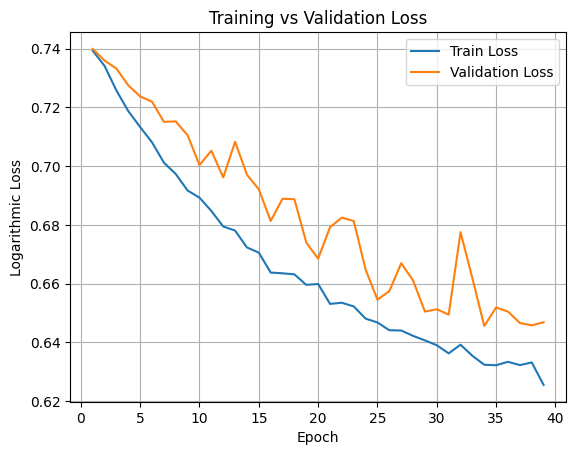

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_df["epoch"], loss_df["train_loss"], label="Train Loss")
plt.plot(loss_df["epoch"], loss_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Logarithmic Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Saving the model

In [ ]:
torch.save(model_early_stopping, "efficientnet_full_model_es1.pth")
print("Model saved to efficientnet_full_model_es1.pth")
from google.colab import files
files.download("efficientnet_full_model_es1.pth")

Model saved to efficientnet_full_model_es1.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Putting 2nd test set in data loader

In [7]:
test2_labels = list(ds_test2['label'])
test2_images = list(ds_test2['image'])

test2_dataset = CustomDataset(test2_images, test2_labels, image_processor)
test2_data_loader = DataLoader(test2_dataset, batch_size=32, shuffle=False, num_workers=0)


Making Predictions using early-stoppage model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import torch

test2_preds_es = []
test2_labels_es = []

model_early_stopping.eval()  # Ensure eval mode
model_early_stopping.to(device)

with torch.no_grad():
    for batch_test2 in test2_data_loader:
        pixel_values_test = batch_test2["pixel_values"].to(device)
        labels = batch_test2["labels"].to(device).float()

        outputs = model_early_stopping(pixel_values=pixel_values_test)
        logits = outputs.logits.squeeze(1)
       # probs = torch.sigmoid(logits)
        preds = (logits > 0.5).float()

        test2_preds_es.extend(preds.cpu().int().tolist())
        test2_labels_es.extend(labels.cpu().int().tolist())

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Early Stopping Model Results

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

test2_preds_es = np.array(test2_preds_es).astype(int).flatten()
test2_labels_es = np.array(test2_labels_es).astype(int).flatten()

# Confirm they are 1D arrays of 0s and 1s
print("test_preds shape:", test2_preds_es.shape)
print("test_labels shape:", test2_labels_es.shape)
print("Sample preds:", test2_preds_es[:10])
print("Sample labels:", test2_labels_es[:10])


cm_es = confusion_matrix(test2_labels_es, test2_preds_es)
print("Confusion Matrix:", cm_es)

print("\nClassification Report:\n")
print(classification_report(test2_labels_es, test2_preds_es, target_names=["Class 0", "Class 1"]))

TN, FP, FN, TP = cm_es.ravel()

# Calculating accuracy, sensitivity, and specificity
accuracy_es = (TP + TN) / (TP + TN + FP + FN)
sensitivity_es = TP / (TP + FN)
specificity_es = TN / (TN + FP)

# Print the metrics
print(f"Accuracy: {accuracy_es:.4f}")
print(f"Sensitivity: {sensitivity_es:.4f}")
print(f"Specificity: {specificity_es:.4f}")

test_preds shape: (1000,)
test_labels shape: (1000,)
Sample preds: [0 0 1 0 1 0 1 1 1 1]
Sample labels: [0 0 1 0 0 0 1 1 1 1]
Confusion Matrix: [[478  34]
 [162 326]]

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.75      0.93      0.83       512
     Class 1       0.91      0.67      0.77       488

    accuracy                           0.80      1000
   macro avg       0.83      0.80      0.80      1000
weighted avg       0.82      0.80      0.80      1000

Accuracy: 0.8040
Sensitivity: 0.6680
Specificity: 0.9336


While Overall Accuracy increased to 80.40% and Specificity increased to 93.36%, Sensitivity dipped to 66.80%. Specificity is the main metric we're concerned with as we want to be able to accuratley predict someone's skin lesion is not melanoma(cancerous) Now investigating adjusting Dropout to see if that can help our model further. Current model's base configuration is 0.5 dropout rate.

Looping over different dropout rates(0.2,0.3,0.4) as base model utilizes 0.5 and background research revealed most CNN's perform the best in 0.2-0.5 range

In [ ]:
from google.colab import files
from sklearn.metrics import confusion_matrix
from transformers import AutoImageProcessor, EfficientNetForImageClassification
import torch.nn as nn
from tqdm import tqdm
from torch import nn, optim

dropout_rates = [0.2, 0.3, 0.4]
best_loss = float('inf')
best_model = None
best_dropout = None

for rate in dropout_rates:
  # Initializing a model (with random weights) from the efficientnet-b7 style configuration
  model_base_dp = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b7")
  model_base_dp = model_base_dp.to(device)
  # Freeze all layers except the classifier
  for param in model_base_dp.parameters():
    param.requires_grad = False

  #Using sigmoid activation for final layer as this dataset is binary classification
  model_base_dp.classifier = nn.Sequential(
    nn.Dropout(p=rate),
    nn.Linear(2560, 1),  # 2560 is the size of the output from EfficientNet-B7
    nn.Sigmoid()         # Sigmoid activation for binary classification
)
  model_base_dp.config.num_labels = 2  # Binary classification: 2 labels (0 and 1)
  model_base_dp.config.id2label = {0: "negative", 1: "positive"}  # Custom labels for binary classification
  #Defining loss function and optimizer
  loss_fn = torch.nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model_base_dp.parameters(), lr=1e-4)
  num_epochs = 10
  model_base_dp = model_base_dp.to(device)

  for epoch in range(num_epochs):
      model_base_dp.train()  # Set model to training mode
      running_loss = 0.0
      for batch in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        pixel_values =batch["pixel_values"].to(device)

        true_labels = batch["labels"].to(device)
        true_labels = true_labels.float()
        inputs = {"pixel_values": pixel_values}

        optimizer.zero_grad()
        outputs = model_base_dp(**inputs)
        logits = outputs.logits.squeeze(1)
        loss = loss_fn(logits, true_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      avg_loss = running_loss / len(data_loader)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}", f"Dropout Rate: {rate}")
  # Save best model (lowest loss so far)
  if avg_loss < best_loss:
    best_loss = avg_loss
    best_model = model_base_dp
    best_dropout = rate
    print(f"New best model found at dropout {rate} (Loss: {avg_loss:.4f})")

if best_model is not None:
    torch.save(best_model, "efficientnet_full_model_dp2.pth")
    print("Model saved to efficientnet_full_model_dp2.pth")
    files.download("efficientnet_full_model_dp2.pth")

Epoch 1/10:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Epoch 1/10, Loss: 0.7238 Dropout Rate: 0.2


Epoch 2/10, Loss: 0.7155 Dropout Rate: 0.2


Epoch 3/10, Loss: 0.7095 Dropout Rate: 0.2


Epoch 4/10, Loss: 0.7037 Dropout Rate: 0.2


Epoch 5/10, Loss: 0.6981 Dropout Rate: 0.2


Epoch 6/10, Loss: 0.6931 Dropout Rate: 0.2


Epoch 7/10, Loss: 0.6872 Dropout Rate: 0.2


Epoch 8/10, Loss: 0.6834 Dropout Rate: 0.2


Epoch 9/10, Loss: 0.6801 Dropout Rate: 0.2


Epoch 10/10, Loss: 0.6745 Dropout Rate: 0.2
New best model found at dropout 0.2 (Loss: 0.6745)


Epoch 1/10, Loss: 0.7205 Dropout Rate: 0.3


Epoch 2/10, Loss: 0.7157 Dropout Rate: 0.3


Epoch 3/10, Loss: 0.7115 Dropout Rate: 0.3


Epoch 4/10, Loss: 0.7069 Dropout Rate: 0.3


Epoch 5/10, Loss: 0.6997 Dropout Rate: 0.3


Epoch 6/10, Loss: 0.6945 Dropout Rate: 0.3


Epoch 7/10, Loss: 0.6910 Dropout Rate: 0.3


Epoch 8/10, Loss: 0.6864 Dropout Rate: 0.3


Epoch 9/10, Loss: 0.6824 Dropout Rate: 0.3


Epoch 10/10, Loss: 0.6785 Dropout Rate: 0.3


Epoch 1/10, Loss: 0.7212 Dropout Rate: 0.4


Epoch 2/10, Loss: 0.7160 Dropout Rate: 0.4


Epoch 3/10, Loss: 0.7102 Dropout Rate: 0.4


Epoch 4/10, Loss: 0.7040 Dropout Rate: 0.4


Epoch 5/10, Loss: 0.7004 Dropout Rate: 0.4


Epoch 6/10, Loss: 0.6953 Dropout Rate: 0.4


Epoch 7/10, Loss: 0.6900 Dropout Rate: 0.4


Epoch 8/10, Loss: 0.6841 Dropout Rate: 0.4


Epoch 9/10, Loss: 0.6833 Dropout Rate: 0.4


Epoch 10/10, Loss: 0.6797 Dropout Rate: 0.4
Model saved to efficientnet_full_model_dp.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model with Dropout Rate of 0.2 performed the best over the first ten epochs. Now adjusting the Dropout Rate of model to  and using Early Stopping to find optimal model performance.

In [ ]:

from torch import nn, optim
# Initializing a model (with random weights) from the efficientnet-b7 style configuration
model_early_stopping_2 = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b7")
model_early_stopping_2 = model_early_stopping_2.to(device)
# Freeze all layers except the classifier
for param in model_early_stopping_2.parameters():
  param.requires_grad = False

#Using sigmoid activation for final layer as this dataset is binary classification
model_early_stopping_2.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(2560, 1),
    nn.Sigmoid()
)
# Binary classification: 2 labels (0 and 1)
model_early_stopping_2.config.num_labels = 2
model_early_stopping_2.config.id2label = {0: "negative", 1: "positive"}

model_early_stopping_2 = model_early_stopping_2.to(device)

#Setting up For Loop Variables
patience = 5
patience_counter = 0
best_val_loss = float('inf')
num_epochs = 250
min_accept_loss = 0.001
model_early_stopping_2 = model_early_stopping_2.to(device)


#making dataframe to track epochs, train_loss, val_loss
import pandas as pd
loss_df2 = pd.DataFrame(columns=["epoch", "train_loss", "val_loss"])


for epoch in range(num_epochs):
  # Set model to training mode
  model_early_stopping_2.train()
  running_loss_train = 0.0
  for batch in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
    pixel_values_train =batch["pixel_values"].to(device)

    true_labels_train = batch["labels"].to(device)
    true_labels_train = true_labels_train.float()
    inputs_train = {"pixel_values": pixel_values_train}

    optimizer.zero_grad()
    outputs_train = model_early_stopping_2(**inputs_train)
    logits_train = outputs_train.logits.squeeze(1)
    loss_train = loss_fn(logits_train, true_labels_train)
    loss_train.backward()
    optimizer.step()
    running_loss_train += loss_train.item()
  avg_loss_train = running_loss_train / len(data_loader)
  print(f"Epoch {epoch+1}, Training Loss: {avg_loss_train:.4f}")

# Set model to evaluation mode
  model_early_stopping_2.eval()
  running_loss_val = 0.0
  with torch.no_grad():
    for batch_val in tqdm(test_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
      pixel_values_val =batch_val["pixel_values"].to(device)
      true_labels_val = batch_val["labels"].to(device)
      true_labels_val = true_labels_val.float()
      inputs_val = {"pixel_values": pixel_values_val}
      outputs_val = model_early_stopping_2(**inputs_val)
      logits_val = outputs_val.logits.squeeze(1)
      loss_val = loss_fn(logits_val, true_labels_val)
      running_loss_val += loss_val.item()
    avg_loss_val = running_loss_val / len(test_data_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_loss_val:.4f}")
    # Append loss info to DataFrame
  loss_df2 = pd.concat([loss_df2,pd.DataFrame.from_dict({"epoch": [epoch + 1],
                                                     "train_loss": [avg_loss_train],
                                                     "val_loss": [avg_loss_val]})],
                                                        ignore_index=True)

  if avg_loss_val < best_val_loss - min_accept_loss:
    best_val_loss = avg_loss_val
    patience_counter = 0
  else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

torch.save(model_early_stopping_2, "efficientnet_full_model_es2.pth")
print("Model saved to efficientnet_full_model_es2.pth")
files.download("efficientnet_full_model_es2.pth")


Epoch 1/250:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Epoch 1, Training Loss: 0.7273


<ipython-input-14-c44befbf251b>:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  loss_df2 = pd.concat([loss_df2,pd.DataFrame.from_dict({"epoch": [epoch + 1],


Epoch 1, Validation Loss: 0.7415


Epoch 2, Training Loss: 0.7281


Epoch 2, Validation Loss: 0.7426


Epoch 3, Training Loss: 0.7254


Epoch 3, Validation Loss: 0.7405


Epoch 4, Training Loss: 0.7258


Epoch 4, Validation Loss: 0.7401


Epoch 5, Training Loss: 0.7257


Epoch 5, Validation Loss: 0.7412


Epoch 6, Training Loss: 0.7278


Epoch 6, Validation Loss: 0.7417


Epoch 7, Training Loss: 0.7269


Epoch 7, Validation Loss: 0.7405


Epoch 8, Training Loss: 0.7260


Epoch 8, Validation Loss: 0.7418


Epoch 9, Training Loss: 0.7261


Epoch 9, Validation Loss: 0.7410
Early stopping at epoch 9
Model saved to efficientnet_full_model_es2.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

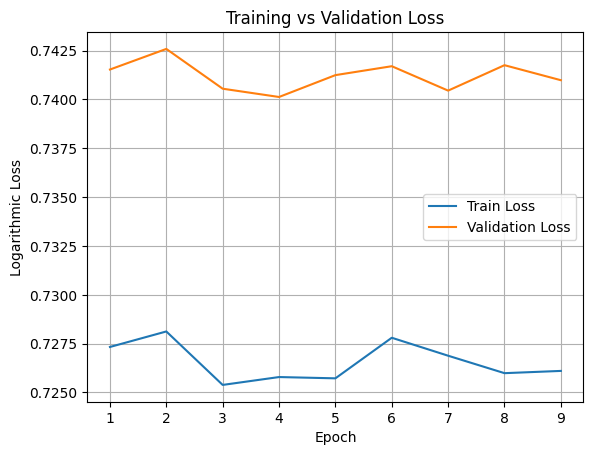

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_df2["epoch"], loss_df2["train_loss"], label="Train Loss")
plt.plot(loss_df2["epoch"], loss_df2["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Logarithmic Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

We can see that using the model with Dropout Rate of 0.2, early stoppage occurs at epoch 9 and the training loss along with validation loss both do not trend downward

Making Predictions with Early Stopping Model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import torch

test_preds_es2 = []
test_labels_es2 = []

model_early_stopping_2.eval()  # Ensure eval mode
model_early_stopping_2.to(device)

with torch.no_grad():
    for batch_test2 in test2_data_loader:
        pixel_values_test = batch_test2["pixel_values"].to(device)
        labels = batch_test2["labels"].to(device).float()

        outputs = model_early_stopping_2(pixel_values=pixel_values_test)
        logits = outputs.logits.squeeze(1)
        preds = (logits > 0.5).float()

        test_preds_es2.extend(preds.cpu().int().tolist())
        test_labels_es2.extend(labels.cpu().int().tolist())

test_preds_es2 = np.array(test_preds_es2).astype(int).flatten()
test_labels_es2 = np.array(test_labels_es2).astype(int).flatten()

# Confirm they are 1D arrays of 0s and 1s
print("test_preds shape:", test_preds_es2.shape)
print("test_labels shape:", test_labels_es2.shape)
print("Sample preds:", test_preds_es2[:10])
print("Sample labels:", test_labels_es2[:10])


cm_es2 = confusion_matrix(test_labels_es2, test_preds_es2)
print("Confusion Matrix:", cm_es2)

print("\nClassification Report:\n")
print(classification_report(test_labels_es2, test_preds_es2, target_names=["Class 0", "Class 1"]))

TN, FP, FN, TP = cm_es2.ravel()

# Calculating accuracy, sensitivity, and specificity
accuracy_es2 = (TP + TN) / (TP + TN + FP + FN)
sensitivity_es2 = TP / (TP + FN)
specificity_es2 = TN / (TN + FP)

# Print the metrics
print(f"Accuracy: {accuracy_es2:.4f}")
print(f"Sensitivity: {sensitivity_es2:.4f}")
print(f"Specificity: {specificity_es2:.4f}")

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


test_preds shape: (1000,)
test_labels shape: (1000,)
Sample preds: [1 0 0 1 0 1 0 1 1 1]
Sample labels: [0 0 0 1 1 1 0 0 1 1]
Confusion Matrix: [[221 314]
 [144 321]]

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.61      0.41      0.49       535
     Class 1       0.51      0.69      0.58       465

    accuracy                           0.54      1000
   macro avg       0.56      0.55      0.54      1000
weighted avg       0.56      0.54      0.53      1000

Accuracy: 0.5420
Sensitivity: 0.6903
Specificity: 0.4131


We can see that choosing what seemed to be the optimal dropout rate of 0.2 and training the model using early stoppage resulted in a much worse model with overall accuracy of 54.20% and a specificity of 41.31%. The baseline model implmeneted with early stoppage with dropout of 0.5 performed much better

**We observed using classical regularization methods such as Drop-out and Early-Stoppage our best model achieved an overall accuracy of: 80.40% and specificity of: 93.36% with Drop-out Rate of 0.5. Now we investigate the efficacy of using the Grey Wolf Optimizer to tune our hyperparameters and how the resulting model performs.**


Tuning the hyperparameters of our best CNN Model


Import

In [8]:
%pip install mealpy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.models import efficientnet_b0
from mealpy.swarm_based.GWO import OriginalGWO
import torch.nn as nn
import torch.optim as optim
from mealpy.utils.space import FloatVar, IntegerVar
from mealpy.utils.problem import Problem



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 86.6 MB/s eta 0:00:00


Creating Custom Dataset Object for GWO algorithm(main change from before custom dataset object is that the labels cannot be strings and must be tensors)

In [9]:
from torch.utils.data import Dataset
import torch
from PIL import Image

class GWOCustomDataset(Dataset):
    def __init__(self, images, labels, processor):
        self.images = images
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # If image is a path or a PIL.Image convert
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        # Process the image using the processor
        processed = self.processor(images=image, return_tensors="pt")
        pixel_values = processed["pixel_values"].squeeze(0)  # remove batch dim

        return pixel_values, torch.tensor(label, dtype=torch.float32)


dataset_GWO = GWOCustomDataset(images, labels, image_processor)
data_loader_GWO = DataLoader(dataset_GWO, batch_size=32, shuffle=True, num_workers=0)

test_dataset_GWO = GWOCustomDataset(test_images, test_labels, image_processor)
test_data_loader_GWO = DataLoader(test_dataset_GWO, batch_size=32, shuffle=False, num_workers=0)



Creating custom object similar to Problem object in older versions of mealpy which specifies the bounds of the tuning hyperparameters for learning rate, convulation filters, and batch size

In [10]:
#Defining problem GWO is optimizing
class CNNHyperparamProblem(Problem):
    def __init__(self):
        super().__init__(
            bounds=[
                FloatVar(0.00001, 0.01),     # learning rate
                FloatVar(0.2, 0.5),          # dropout rate
                IntegerVar(64, 512),        # fc neurons
            ],
            minmax="min",
            name="CNNHyperparamOptimization",
            log_to=None
        )

    def obj_func(self, solution):
        return fitness_function(solution)

Defining the fitness function for GWO algorithm: training the base deep learning model with the current solution's hyperparameters and returning the loss that GWO is minimizing

In [11]:
# Load pretrained EfficientNet
base_model_GWO = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b7")


def fitness_function(agent):
    lr = float(agent[0])
    dropout_rate = float(agent[1])
    fc_neurons = int(agent[2])

    for param in base_model_GWO.parameters():
      param.requires_grad = False

    # Rebuild the classifier layer
    base_model_GWO.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(2560, fc_neurons),
    nn.ReLU(),
    nn.Linear(fc_neurons, 1),
    nn.Sigmoid())

    device = torch.device("cuda")
    model = base_model_GWO.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    num_epochs = 2

    #Setting model to train mode
    for epoch in range(2):
      model.train()
      running_loss_train = 0.0
      for batch in tqdm(data_loader_GWO, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            pixel_values_train, true_labels_train = batch
            pixel_values_train = pixel_values_train.to(device)
            true_labels_train = true_labels_train.to(device).float()

            optimizer.zero_grad()
            outputs_train = model(pixel_values_train)
            logits_train = outputs_train.logits.squeeze(1)
            loss_train = criterion(logits_train, true_labels_train)
            loss_train.backward()
            optimizer.step()
            running_loss_train += loss_train.item()

      avg_loss_train = running_loss_train / len(data_loader_GWO)

      model.eval()
      running_loss_val = 0.0
      correct = 0
      with torch.no_grad():
          for batch_val in tqdm(test_data_loader_GWO, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
              pixel_values_val, true_labels_val = batch_val
              pixel_values_val = pixel_values_val.to(device)
              true_labels_val = true_labels_val.to(device).float()

              outputs_val = model(pixel_values_val)
              logits_val = outputs_val.logits.squeeze(1)
              loss_val = criterion(logits_val, true_labels_val)
              running_loss_val += loss_val.item()

              preds = (logits_val > 0.5).float()
              correct += preds.eq(true_labels_val).sum().item()

      avg_loss_val = running_loss_val / len(test_data_loader_GWO)
      accuracy = correct / len(test_dataset)
      print(f"Epoch {epoch+1}, Validation Loss: {avg_loss_val:.4f}, Accuracy: {accuracy:.4f}")

    return 1 - accuracy

Utilizing GWO algorithm initializing solutions and updating the position of every solution iterativley to find best possible hyperparameters for model

In [ ]:
# Instantiate the problem
problem = CNNHyperparamProblem()
model = OriginalGWO(epoch=5, pop_size=5)
best_agent = model.solve(problem)

print("\nBest Hyperparameters:")
print("Position (hyperparameters):", best_agent.solution)
print("Fitness (1 - accuracy):", best_agent.target.fitness)

best_position = best_agent.solution
best_fit = best_agent.target.fitness

print("\nBest Hyperparameters (Formatted):")
print(f"Learning Rate: {best_position[0]:.5f}")
print(f"Dropout Rate: {best_position[1]:.4f}")
print(f"Final Classifier Neurons: {int(best_position[2])}")
print(f"Validation Accuracy: {1 - best_fit:.4f}")


Epoch 1, Validation Loss: 0.6135, Accuracy: 0.7647


Epoch 2, Validation Loss: 0.5509, Accuracy: 0.7916


Epoch 1, Validation Loss: 0.4473, Accuracy: 0.8042


Epoch 2, Validation Loss: 0.4385, Accuracy: 0.8000


Epoch 1, Validation Loss: 0.5172, Accuracy: 0.7882


Epoch 2, Validation Loss: 0.4334, Accuracy: 0.8227


Epoch 1, Validation Loss: 0.4036, Accuracy: 0.8168


Epoch 2, Validation Loss: 0.3794, Accuracy: 0.8353


Epoch 1, Validation Loss: 0.4182, Accuracy: 0.8218


Epoch 2, Validation Loss: 0.3727, Accuracy: 0.8454


Epoch 1, Validation Loss: 0.4091, Accuracy: 0.8218


Epoch 2, Validation Loss: 0.3835, Accuracy: 0.8176


Epoch 1, Validation Loss: 0.5564, Accuracy: 0.7479


Epoch 2, Validation Loss: 0.3927, Accuracy: 0.8412


Epoch 1, Validation Loss: 0.3992, Accuracy: 0.8252


Epoch 2, Validation Loss: 0.4232, Accuracy: 0.8151


Epoch 1, Validation Loss: 0.4157, Accuracy: 0.8202


Epoch 2, Validation Loss: 0.5614, Accuracy: 0.7697


Epoch 1, Validation Loss: 0.6843, Accuracy: 0.6966


Epoch 2, Validation Loss: 0.4092, Accuracy: 0.8118


Epoch 1, Validation Loss: 0.3910, Accuracy: 0.8269


Epoch 2, Validation Loss: 0.4051, Accuracy: 0.8244


Epoch 1, Validation Loss: 0.4097, Accuracy: 0.8151


Epoch 2, Validation Loss: 0.3660, Accuracy: 0.8378


Epoch 1, Validation Loss: 0.4325, Accuracy: 0.7916


Epoch 2, Validation Loss: 0.3966, Accuracy: 0.8252


Epoch 1, Validation Loss: 0.3975, Accuracy: 0.8269


Epoch 2, Validation Loss: 0.3940, Accuracy: 0.8387


Epoch 1, Validation Loss: 0.5434, Accuracy: 0.7655


Epoch 2, Validation Loss: 0.4353, Accuracy: 0.8034


Epoch 1, Validation Loss: 0.4539, Accuracy: 0.7874


Epoch 2, Validation Loss: 0.3828, Accuracy: 0.8252


Epoch 1, Validation Loss: 0.3828, Accuracy: 0.8319


Epoch 2, Validation Loss: 0.5018, Accuracy: 0.7899


Epoch 1, Validation Loss: 0.3895, Accuracy: 0.8227


Epoch 2, Validation Loss: 0.5705, Accuracy: 0.7950


Epoch 1, Validation Loss: 0.5059, Accuracy: 0.7521


Epoch 2, Validation Loss: 0.5036, Accuracy: 0.7773


Epoch 1, Validation Loss: 0.4130, Accuracy: 0.8076


Epoch 2, Validation Loss: 0.4022, Accuracy: 0.8387


Epoch 1, Validation Loss: 0.4222, Accuracy: 0.8168


Epoch 2, Validation Loss: 0.3786, Accuracy: 0.8429


Epoch 1, Validation Loss: 0.5188, Accuracy: 0.7605


Epoch 2, Validation Loss: 0.3845, Accuracy: 0.8378


Epoch 1, Validation Loss: 0.4602, Accuracy: 0.7756


Epoch 2, Validation Loss: 0.4216, Accuracy: 0.8067


Epoch 1, Validation Loss: 0.4030, Accuracy: 0.8294


Epoch 2, Validation Loss: 0.3982, Accuracy: 0.8269


Epoch 1, Validation Loss: 0.3920, Accuracy: 0.8218


Epoch 2, Validation Loss: 0.4604, Accuracy: 0.8134


Epoch 1, Validation Loss: 0.4370, Accuracy: 0.7992


Epoch 2, Validation Loss: 0.4606, Accuracy: 0.8034


Epoch 1, Validation Loss: 0.4514, Accuracy: 0.7857


Epoch 2, Validation Loss: 0.3912, Accuracy: 0.8336


Epoch 1, Validation Loss: 0.4337, Accuracy: 0.8092


Epoch 2, Validation Loss: 0.3744, Accuracy: 0.8303


Epoch 1, Validation Loss: 0.4078, Accuracy: 0.8101


Epoch 2, Validation Loss: 0.4340, Accuracy: 0.8000


Epoch 1, Validation Loss: 0.4856, Accuracy: 0.7815


Epoch 2, Validation Loss: 0.3537, Accuracy: 0.8504


Epoch 1, Validation Loss: 0.4124, Accuracy: 0.8042


Epoch 2, Validation Loss: 0.3660, Accuracy: 0.8454

Best Hyperparameters:
Position (hyperparameters): [1.84397442e-03 3.15383906e-01 3.58471322e+02]
Fitness (1 - accuracy): 0.14957983193277313

Best Hyperparameters (Formatted):
Learning Rate: 0.00184
Dropout Rate: 0.3154
Final Classifier Neurons: 358
Validation Accuracy: 0.8504


Printing Formatted best Hyperparameters


Creating new model with the optimal hyperparameters obtained from the GWO algorithm

In [ ]:
dropout_rate = 0.3154
fc_neurons = 358
lr = 0.00184


gwo_model = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b7")
for param in gwo_model.parameters():
    param.requires_grad = False

# Custom GWO classifier
gwo_model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(2560, fc_neurons),
    nn.ReLU(),
    nn.Linear(fc_neurons, 1),
    nn.Sigmoid()
)

device = torch.device("cuda")
gwo_model = gwo_model.to(device)

optimizer = torch.optim.Adam(gwo_model.parameters(), lr=lr)

from google.colab import files


Training GWO's tuned hyperparameters model and implementing early stoppage

In [ ]:
#Setting up For Loop Variables
patience = 5
patience_counter = 0
best_val_loss = float('inf')
num_epochs = 250
min_accept_loss = 0.001
gwo_model = gwo_model.to(device)

#making dataframe to track epochs, train_loss, val_loss
import pandas as pd
loss_df5 = pd.DataFrame(columns=["epoch", "train_loss", "val_loss"])


for epoch in range(num_epochs):
  # Set model to training mode
  gwo_model.train()
  running_loss_train = 0.0
  for batch in tqdm(test_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
    pixel_values_train =batch["pixel_values"].to(device)

    true_labels_train = batch["labels"].to(device)
    true_labels_train = true_labels_train.float()
    inputs_train = {"pixel_values": pixel_values_train}

    optimizer.zero_grad()
    outputs_train = gwo_model(**inputs_train)
    logits_train = outputs_train.logits.squeeze(1)
    loss_train = loss_fn(logits_train, true_labels_train)
    loss_train.backward()
    optimizer.step()
    running_loss_train += loss_train.item()
  avg_loss_train = running_loss_train / len(test_data_loader)
  print(f"Epoch {epoch+1}, Training Loss: {avg_loss_train:.4f}")

# Set model to evaluation mode
  gwo_model.eval()
  running_loss_val = 0.0
  with torch.no_grad():
    for batch_val in tqdm(test2_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
      pixel_values_val =batch_val["pixel_values"].to(device)
      true_labels_val = batch_val["labels"].to(device)
      true_labels_val = true_labels_val.float()
      inputs_val = {"pixel_values": pixel_values_val}
      outputs_val = gwo_model(**inputs_val)
      logits_val = outputs_val.logits.squeeze(1)
      loss_val = loss_fn(logits_val, true_labels_val)
      running_loss_val += loss_val.item()
    avg_loss_val = running_loss_val / len(test2_data_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_loss_val:.4f}")
    # Append loss info to DataFrame
  loss_df5 = pd.concat([loss_df5,pd.DataFrame.from_dict({"epoch": [epoch + 1],
                                                     "train_loss": [avg_loss_train],
                                                     "val_loss": [avg_loss_val]})],
                                                        ignore_index=True)

  if avg_loss_val < best_val_loss - min_accept_loss:
    best_val_loss = avg_loss_val
    patience_counter = 0
  else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

torch.save(gwo_model, "efficientnet_gwo_model.pth")
print("Model saved to efficientnet_gwo_model.pth")
files.download("efficientnet_gwo_model.pth")

Epoch 1/250:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Epoch 1, Training Loss: 0.6318


<ipython-input-16-a4b2882b6b89>:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  loss_df5 = pd.concat([loss_df5,pd.DataFrame.from_dict({"epoch": [epoch + 1],


Epoch 1, Validation Loss: 0.6142


Epoch 2, Training Loss: 0.5903


Epoch 2, Validation Loss: 0.6065


Epoch 3, Training Loss: 0.5848


Epoch 3, Validation Loss: 0.6051


Epoch 4, Training Loss: 0.5756


Epoch 4, Validation Loss: 0.6000


Epoch 5, Training Loss: 0.5698


Epoch 5, Validation Loss: 0.5943


Epoch 6, Training Loss: 0.5722


Epoch 6, Validation Loss: 0.5918


Epoch 7, Training Loss: 0.5690


Epoch 7, Validation Loss: 0.5967


Epoch 8, Training Loss: 0.5652


Epoch 8, Validation Loss: 0.5962


Epoch 9, Training Loss: 0.5590


Epoch 9, Validation Loss: 0.5911


Epoch 10, Training Loss: 0.5623


Epoch 10, Validation Loss: 0.5880


Epoch 11, Training Loss: 0.5559


Epoch 11, Validation Loss: 0.5877


Epoch 12, Training Loss: 0.5564


Epoch 12, Validation Loss: 0.5878


Epoch 13, Training Loss: 0.5571


Epoch 13, Validation Loss: 0.5929


Epoch 14, Training Loss: 0.5520


Epoch 14, Validation Loss: 0.5922


Epoch 15, Training Loss: 0.5512


Epoch 15, Validation Loss: 0.5912
Early stopping at epoch 15
Model saved to efficientnet_gwo_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plotting Training Loss vs. Validation Loss

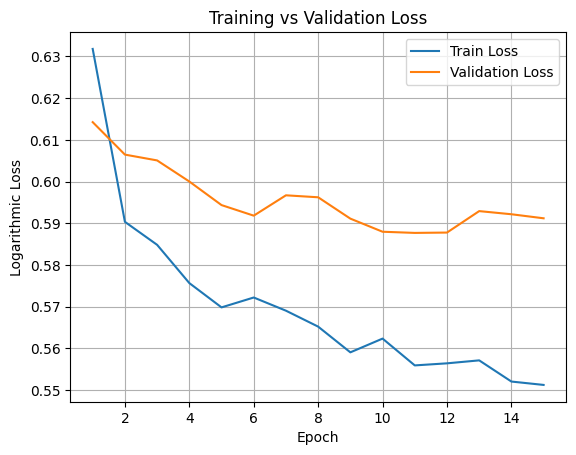

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_df5["epoch"], loss_df5["train_loss"], label="Train Loss")
plt.plot(loss_df5["epoch"], loss_df5["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Logarithmic Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Making Predictions to evaluate performance

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import torch

test_preds_gwo_es = []
test_labels_gwo_es = []

gwo_model.eval()  # Ensure eval mode
gwo_model.to(device)

with torch.no_grad():
    for batch_test2 in test2_data_loader:
        pixel_values_test = batch_test2["pixel_values"].to(device)
        labels = batch_test2["labels"].to(device).float()

        outputs = gwo_model(pixel_values=pixel_values_test)
        logits = outputs.logits.squeeze(1)
        preds = (logits > 0.5).float()

        test_preds_gwo_es.extend(preds.cpu().int().tolist())
        test_labels_gwo_es.extend(labels.cpu().int().tolist())

test_preds_gwo_es = np.array(test_preds_gwo_es).astype(int).flatten()
test_labels_gwo_es = np.array(test_labels_gwo_es).astype(int).flatten()

# Confirm they are 1D arrays of 0s and 1s
print("test_preds shape:", test_preds_gwo_es.shape)
print("test_labels shape:", test_labels_gwo_es.shape)
print("Sample preds:", test_preds_gwo_es[:10])
print("Sample labels:", test_labels_gwo_es[:10])


cm_gwo_es = confusion_matrix(test_labels_gwo_es, test_preds_gwo_es)
print("Confusion Matrix:", cm_gwo_es)

print("\nClassification Report:\n")
print(classification_report(test_labels_gwo_es, test_preds_gwo_es, target_names=["Class 0", "Class 1"]))

TN, FP, FN, TP = cm_gwo_es.ravel()

# Calculating accuracy, sensitivity, and specificity
accuracy_gwo_es = (TP + TN) / (TP + TN + FP + FN)
sensitivity_gwo_es = TP / (TP + FN)
specificity_gwo_es = TN / (TN + FP)

# Print the metrics
print(f"Accuracy: {accuracy_gwo_es:.4f}")
print(f"Sensitivity: {sensitivity_gwo_es:.4f}")
print(f"Specificity: {specificity_gwo_es:.4f}")

test_preds shape: (1000,)
test_labels shape: (1000,)
Sample preds: [0 1 1 1 1 0 0 1 0 0]
Sample labels: [0 1 1 1 1 1 0 0 1 0]
Confusion Matrix: [[470  60]
 [102 368]]

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.82      0.89      0.85       530
     Class 1       0.86      0.78      0.82       470

    accuracy                           0.84      1000
   macro avg       0.84      0.83      0.84      1000
weighted avg       0.84      0.84      0.84      1000

Accuracy: 0.8380
Sensitivity: 0.7830
Specificity: 0.8868


Based on the performance of the model made from GWO algorithm's optimal hyperparameters evaluated with early stoppage we can conclude that the best performing model of all evaluated was the early stopping model made with the Grey Wolf Optimizer's tuned hyperparameters as this model had the highest overall accuracy of 83.80% and the highest specificity of 88.68%.

**Now Evaluating Best Performing Model on whole training set using early stoppage**

Preparing Training data to be trained on by creating data loader

In [12]:
train_labels = list(ds_train['label'])
train_images = list(ds_train['image'])

train_dataset = CustomDataset(train_images, train_labels, image_processor)
train_data_loader = DataLoader(train_dataset, batch_size=48, shuffle=False, num_workers=0)


test3_labels = list(ds_test3['label'])
test3_images = list(ds_test3['image'])

test3_dataset = CustomDataset(test3_images, test3_labels, image_processor)
test3_data_loader = DataLoader(test3_dataset, batch_size=48, shuffle=False, num_workers=0)

Implementing Early Stoppage Model with Grey Wolf Optimizer's tuned hyperparameters.

In [ ]:
dropout_rate = 0.3154
fc_neurons = 358
lr = 0.00184


model = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b7")
for param in model.parameters():
    param.requires_grad = False

# Custom GWO classifier
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(2560, fc_neurons),
    nn.ReLU(),
    nn.Linear(fc_neurons, 1),
    nn.Sigmoid()
)

device = torch.device("cuda")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.BCEWithLogitsLoss()
from google.colab import files

In [ ]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

best_performing_model = model
best_performing_model = best_performing_model.to(device)

#Setting up For Loop Variables
patience = 5
patience_counter = 0
best_val_loss = float('inf')
num_epochs = 250
min_accept_loss = 0.001
best_performing_model = best_performing_model.to(device)

#making dataframe to track epochs, train_loss, val_loss
import pandas as pd
loss_df4 = pd.DataFrame(columns=["epoch", "train_loss", "val_loss"])


for epoch in range(num_epochs):
  # Set model to training mode
  best_performing_model.train()
  running_loss_train = 0.0
  for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
    pixel_values_train =batch["pixel_values"].to(device)

    true_labels_train = batch["labels"].to(device)
    true_labels_train = true_labels_train.float()
    inputs_train = {"pixel_values": pixel_values_train}

    optimizer.zero_grad()
    with autocast():

      outputs_train = best_performing_model(**inputs_train)
      logits_train = outputs_train.logits.squeeze(1)
      loss_train = loss_fn(logits_train, true_labels_train)

    scaler.scale(loss_train).backward()
    scaler.step(optimizer)
    scaler.update()
    #loss_train.backward()
    #optimizer.step()
    running_loss_train += loss_train.item()
  avg_loss_train = running_loss_train / len(train_data_loader)
  print(f"Epoch {epoch+1}, Training Loss: {avg_loss_train:.4f}")

# Set model to evaluation mode
  best_performing_model.eval()
  running_loss_val = 0.0
  with torch.no_grad():
    for batch_val in tqdm(test3_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
      pixel_values_val =batch_val["pixel_values"].to(device)
      true_labels_val = batch_val["labels"].to(device)
      true_labels_val = true_labels_val.float()
      inputs_val = {"pixel_values": pixel_values_val}

      with autocast():
        outputs_val = best_performing_model(**inputs_val)
        logits_val = outputs_val.logits.squeeze(1)
        loss_val = loss_fn(logits_val, true_labels_val)
      running_loss_val += loss_val.item()
    avg_loss_val = running_loss_val / len(test3_data_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_loss_val:.4f}")
    # Append loss info to DataFrame
  loss_df4 = pd.concat([loss_df4,pd.DataFrame.from_dict({"epoch": [epoch + 1],
                                                     "train_loss": [avg_loss_train],
                                                     "val_loss": [avg_loss_val]})],
                                                        ignore_index=True)

  if avg_loss_val < best_val_loss - min_accept_loss:
    best_val_loss = avg_loss_val
    patience_counter = 0
  else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

torch.save(best_performing_model, "efficientnet_best_performing_model.pth")
print("Model saved to efficientnet_best_performing_model.pth")
files.download("efficientnet_best_performing_model.pth")

<ipython-input-10-40b157a9d736>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/250:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
<ipython-input-10-40b157a9d736>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Training Loss: 0.5948


Epoch 1/250:   0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-10-40b157a9d736>:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-10-40b157a9d736>:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  loss_df4 = pd.concat([loss_df4,pd.DataFrame.from_dict({"epoch": [epoch + 1],


Epoch 1, Validation Loss: 0.5889


Epoch 2, Training Loss: 0.5788


Epoch 2, Validation Loss: 0.5849


Epoch 3, Training Loss: 0.5772


Epoch 3, Validation Loss: 0.5857


Epoch 4, Training Loss: 0.5744


Epoch 4, Validation Loss: 0.5830


Epoch 5, Training Loss: 0.5704


Epoch 5, Validation Loss: 0.5831


Epoch 6, Training Loss: 0.5686


Epoch 6, Validation Loss: 0.5810


Epoch 7, Training Loss: 0.5641


Epoch 7, Validation Loss: 0.5812


Epoch 8, Training Loss: 0.5635


Epoch 8, Validation Loss: 0.5838


Epoch 9, Training Loss: 0.5629


Epoch 9, Validation Loss: 0.5869


Epoch 10, Training Loss: 0.5618


Epoch 10, Validation Loss: 0.5818


Epoch 11, Training Loss: 0.5606


Epoch 11, Validation Loss: 0.5797


Epoch 12, Training Loss: 0.5590


Epoch 12, Validation Loss: 0.5791


Epoch 13, Training Loss: 0.5564


Epoch 13, Validation Loss: 0.5808


Epoch 14, Training Loss: 0.5573


Epoch 14, Validation Loss: 0.5802


Epoch 15, Training Loss: 0.5547


Epoch 15, Validation Loss: 0.5754


Epoch 16, Training Loss: 0.5532


Epoch 16, Validation Loss: 0.5755


Epoch 17, Training Loss: 0.5520


Epoch 17, Validation Loss: 0.5734


Epoch 18, Training Loss: 0.5506


Epoch 18, Validation Loss: 0.5765


Epoch 19, Training Loss: 0.5511


Epoch 19, Validation Loss: 0.5805


Epoch 20, Training Loss: 0.5503


Epoch 20, Validation Loss: 0.5796


Epoch 21, Training Loss: 0.5483


Epoch 21, Validation Loss: 0.5802


Epoch 22, Training Loss: 0.5493


Epoch 22, Validation Loss: 0.5797
Early stopping at epoch 22
Model saved to efficientnet_best_performing_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plotting Training Loss vs. Validation Loss

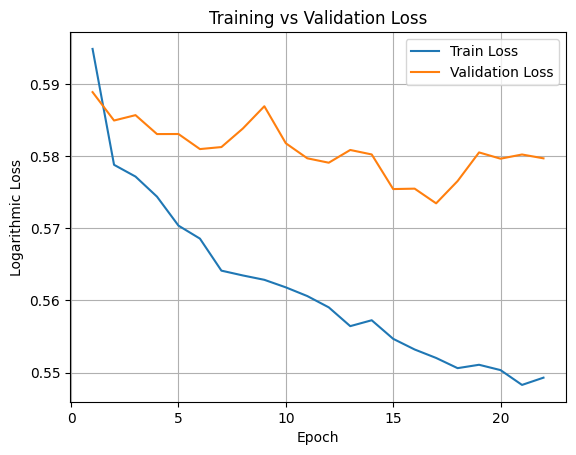

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_df4["epoch"], loss_df4["train_loss"], label="Train Loss")
plt.plot(loss_df4["epoch"], loss_df4["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Logarithmic Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Running for more iterations to visualize point at where early stoppage occurs during 22th epoch as shown before is true point where model should stop training to reduce overfitting.

In [15]:
from torch.cuda.amp import autocast, GradScaler
from google.colab import files
scaler = GradScaler()

best_performing_model = torch.load("sample_data/efficientnet_best_performing_model.pth", weights_only=False)
best_performing_model = best_performing_model.to(device)

optimizer = torch.optim.Adam(best_performing_model.parameters(), lr=0.00184)
loss_fn = torch.nn.BCEWithLogitsLoss()


#Setting up For Loop Variables

num_epochs = 20

best_performing_model = best_performing_model.to(device)

#making dataframe to track epochs, train_loss, val_loss
import pandas as pd
loss_df4 = pd.DataFrame(columns=["epoch", "train_loss", "val_loss"])


for epoch in range(num_epochs):
  # Set model to training mode
  best_performing_model.train()
  running_loss_train = 0.0
  for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
    pixel_values_train =batch["pixel_values"].to(device)

    true_labels_train = batch["labels"].to(device)
    true_labels_train = true_labels_train.float()
    inputs_train = {"pixel_values": pixel_values_train}

    optimizer.zero_grad()
    with autocast():

      outputs_train = best_performing_model(**inputs_train)
      logits_train = outputs_train.logits.squeeze(1)
      loss_train = loss_fn(logits_train, true_labels_train)

    scaler.scale(loss_train).backward()
    scaler.step(optimizer)
    scaler.update()
    #loss_train.backward()
    #optimizer.step()
    running_loss_train += loss_train.item()
  avg_loss_train = running_loss_train / len(train_data_loader)
  print(f"Epoch {epoch+1}, Training Loss: {avg_loss_train:.4f}")

# Set model to evaluation mode
  best_performing_model.eval()
  running_loss_val = 0.0
  with torch.no_grad():
    for batch_val in tqdm(test3_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
      pixel_values_val =batch_val["pixel_values"].to(device)
      true_labels_val = batch_val["labels"].to(device)
      true_labels_val = true_labels_val.float()
      inputs_val = {"pixel_values": pixel_values_val}

      with autocast():
        outputs_val = best_performing_model(**inputs_val)
        logits_val = outputs_val.logits.squeeze(1)
        loss_val = loss_fn(logits_val, true_labels_val)
      running_loss_val += loss_val.item()
    avg_loss_val = running_loss_val / len(test3_data_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_loss_val:.4f}")






<ipython-input-15-29d5573e06f5>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `EfficientNetImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
<ipython-input-15-29d5573e06f5>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Training Loss: 0.5646


Epoch 1/20:   0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-15-29d5573e06f5>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Validation Loss: 0.5619


Epoch 2, Training Loss: 0.5615


Epoch 2, Validation Loss: 0.5626


Epoch 3, Training Loss: 0.5601


Epoch 3, Validation Loss: 0.5649


Epoch 4, Training Loss: 0.5584


Epoch 4, Validation Loss: 0.5646


Epoch 5, Training Loss: 0.5571


Epoch 5, Validation Loss: 0.5638


Epoch 6, Training Loss: 0.5568


Epoch 6, Validation Loss: 0.5626


Epoch 7, Training Loss: 0.5554


Epoch 7, Validation Loss: 0.5652


Epoch 8, Training Loss: 0.5528


Epoch 8, Validation Loss: 0.5672


Epoch 9, Training Loss: 0.5524


Epoch 9, Validation Loss: 0.5666


Epoch 10, Training Loss: 0.5510


Epoch 10, Validation Loss: 0.5676


Epoch 11, Training Loss: 0.5500


Epoch 11, Validation Loss: 0.5664


Epoch 12, Training Loss: 0.5491


Epoch 12, Validation Loss: 0.5684


Epoch 13, Training Loss: 0.5481


Epoch 13, Validation Loss: 0.5658


Epoch 14, Training Loss: 0.5493


Epoch 14, Validation Loss: 0.5669


Epoch 15, Training Loss: 0.5485


Epoch 15, Validation Loss: 0.5653


Epoch 16, Training Loss: 0.5468


Epoch 16, Validation Loss: 0.5707


Epoch 17, Training Loss: 0.5474


Epoch 17, Validation Loss: 0.5651


Epoch 18, Training Loss: 0.5443


Epoch 18, Validation Loss: 0.5630


Epoch 19, Training Loss: 0.5442


Epoch 19, Validation Loss: 0.5653


Epoch 20, Training Loss: 0.5446


Epoch 20, Validation Loss: 0.5649


Plotting Training vs. Validation Loss

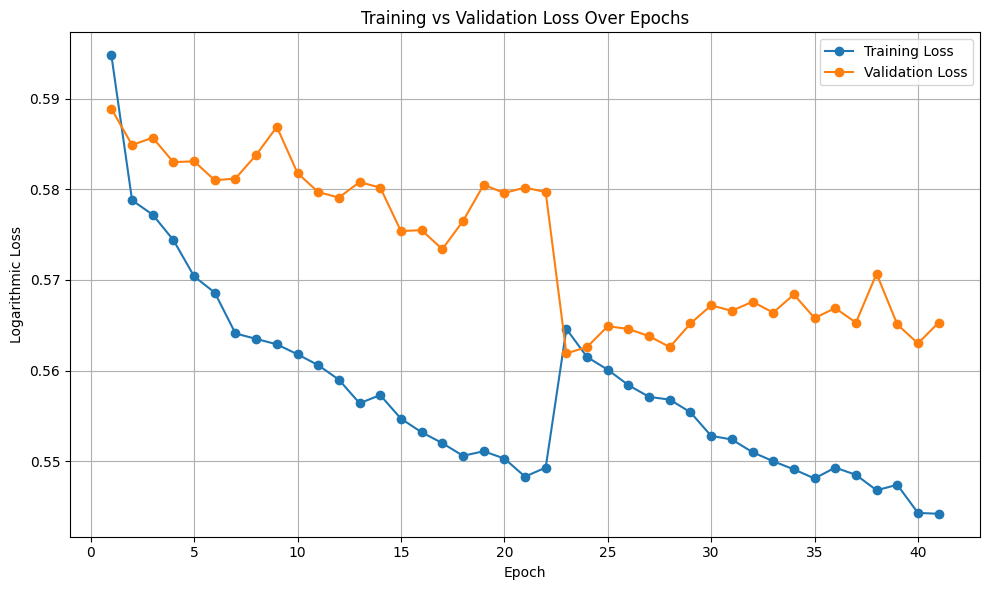

In [6]:
import matplotlib.pyplot as plt

# Loss values from output
train_loss = [
    0.5948, 0.5788, 0.5772, 0.5744, 0.5704, 0.5686, 0.5641, 0.5635, 0.5629, 0.5618,
    0.5606, 0.5590, 0.5564, 0.5573, 0.5547, 0.5532, 0.5520, 0.5506, 0.5511, 0.5503,
    0.5483, 0.5493, 0.5646, 0.5615, 0.5601, 0.5584, 0.5571, 0.5568, 0.5554, 0.5528,
    0.5524, 0.5510, 0.5500, 0.5491, 0.5481, 0.5493, 0.5485, 0.5468, 0.5474, 0.5443,
    0.5442
]

val_loss = [
    0.5889, 0.5849, 0.5857, 0.5830, 0.5831, 0.5810, 0.5812, 0.5838, 0.5869, 0.5818,
    0.5797, 0.5791, 0.5808, 0.5802, 0.5754, 0.5755, 0.5734, 0.5765, 0.5805, 0.5796,
    0.5802, 0.5797, 0.5619, 0.5626, 0.5649, 0.5646, 0.5638, 0.5626, 0.5652, 0.5672,
    0.5666, 0.5676, 0.5664, 0.5684, 0.5658, 0.5669, 0.5653, 0.5707, 0.5651, 0.5630,
    0.5653
]


epochs = list(range(1, 42))  # Starting from epoch 2 since epoch 1 was skipped

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Logarithmic Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Making Predictions to Evaluate Final Model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import torch

test_preds_bfm_es = []
test_labels_bfm_es = []

best_performing_model.eval()  # Ensure eval mode
best_performing_model.to(device)

with torch.no_grad():
    for batch_test2 in test2_data_loader:
        pixel_values_test = batch_test2["pixel_values"].to(device)
        labels = batch_test2["labels"].to(device).float()

        outputs = best_performing_model(pixel_values=pixel_values_test)
        logits = outputs.logits.squeeze(1)
        preds = (logits > 0.5).float()

        test_preds_bfm_es.extend(preds.cpu().int().tolist())
        test_labels_bfm_es.extend(labels.cpu().int().tolist())

test_preds_bfm_es = np.array(test_preds_bfm_es).astype(int).flatten()
test_labels_bfm_es= np.array(test_labels_bfm_es).astype(int).flatten()

# Confirm they are 1D arrays of 0s and 1s
print("test_preds shape:", test_preds_bfm_es.shape)
print("test_labels shape:", test_labels_bfm_es.shape)
print("Sample preds:", test_preds_bfm_es[:10])
print("Sample labels:", test_labels_bfm_es[:10])


cm_bfm_es = confusion_matrix(test_labels_bfm_es, test_preds_bfm_es)
print("Confusion Matrix:", cm_bfm_es)

print("\nClassification Report:\n")
print(classification_report(test_labels_bfm_es, test_preds_bfm_es, target_names=["Class 0", "Class 1"]))

TN, FP, FN, TP = cm_bfm_es.ravel()

# Calculating accuracy, sensitivity, and specificity
accuracy_bfm_es = (TP + TN) / (TP + TN + FP + FN)
sensitivity_bfm_es = TP / (TP + FN)
specificity_bfm_es= TN / (TN + FP)

# Print the metrics
print(f"Accuracy: {accuracy_bfm_es:.4f}")
print(f"Sensitivity: {sensitivity_bfm_es:.4f}")
print(f"Specificity: {specificity_bfm_es:.4f}")

test_preds shape: (1000,)
test_labels shape: (1000,)
Sample preds: [1 0 0 0 0 0 1 0 1 0]
Sample labels: [1 0 0 0 0 0 1 0 1 0]
Confusion Matrix: [[469  33]
 [108 390]]

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.81      0.93      0.87       502
     Class 1       0.92      0.78      0.85       498

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000

Accuracy: 0.8590
Sensitivity: 0.7831
Specificity: 0.9343


The final model trained over all the training data and evaluated on a held out unseen test dataset using the tuned hyperparameters from the Grey Wolf Optimizer produced the best model with an overall accuracy of 85.90% and a specificity of 93.43%.
